In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
#import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "Generate map for simple example"
nb_name = "nb_seqsim_simple_ex_gen"

# Surface

In [2]:
shn = 20

surface = SDSS(comment, N_SH = shn, sim_type = "core")

#glq_r = surface.r_cmb
glq_r = 1

surface.grid_glq(nmax = shn, r_at = glq_r)

grid_in = np.array([surface.grid_glq_phi, 90-surface.grid_glq_theta]).T
surface.make_grid(glq_r, grid_in, calc_sph_d = True)

#surface.generate_map(target_var_factor = 1)

In [3]:
print(surface)


______current attributes______

a:                  6371.2
r_sat:              6721.2
r_cmb:              3480.0
rad:                0.017453292519943295
mu0:                1.2566370614359173e-06
comment:            Generate map for simple example
class_abs_path:     /home/mikotz/spherical_direct_sequential_simulation
N_SH:               20
N_SH_secondary:     None
sim_type:           core
grid_glq_zero:      (21,), Max/Min: 0.99 / -0.99
grid_glq_w_shtools: (21,), Max/Min: 0.15 / 0.02
grid_glq_shape:     (2,), Max/Min: 41.00 / 21.00
grid_glq_w:         (861,), Max/Min: 0.15 / 0.02
grid_glq_radial:    (861,), Max/Min: 1.00 / 1.00
grid_glq_theta:     (861,), Max/Min: 173.59 / 6.41
grid_glq_phi:       (861,), Max/Min: 351.22 / 0.00
grid_glq_N:         861
grid_glq_nmax:      20
r_grid:             1
grid:               (861, 2)
sph_d:              (861, 861)
lon:                (861,), Max/Min: 351.22 / 0.00
lat:                (861,), Max/Min: 83.59 / -83.59
N_grid:             861



In [4]:
surface.condtab(model_hist = "laplace", normsize=1000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 101, rangv_lim = 2.0, rangv_N = 101)

In [5]:
surface.attribute_string_update_print()


______new attributes______

data:               (861,), Max/Min: 7.60 / -9.08
target_var:         2.0026439675799117
target_mean:        0.0
g_prior:            (441,), Max/Min: 0.13 / -0.16
g_cilm:             (2, 21, 21)
CQF_dist:           (101, 101, 1000)
CQF_mean:           (101, 101)
CQF_var:            (101, 101)
rangv:              (101,), Max/Min: 2.00 / 0.00
rangn:              (101,), Max/Min: 3.50 / -3.50
condtab_normsize:   1000
condtab_model_hist: laplace
condtab_table:      rough



In [6]:
import numpy as np
import scipy.interpolate as interpolate

def inverse_transform_sampling(data, n_bins=40, n_samples=1000):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)

    return inv_cdf(r)

<IPython.core.display.Javascript object>


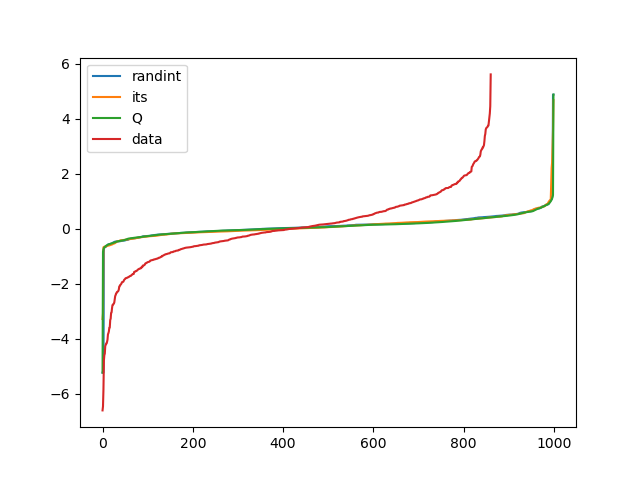

In [20]:
i_n = 51
i_v = 5

its_samp = inverse_transform_sampling(surface.CQF_dist[i_n,i_v,:], n_bins=40, n_samples=1000)

plt.figure()
plt.plot(np.sort(surface.CQF_dist[i_n,i_v,np.random.randint(0,surface.condtab_normsize,size=1000)]),label="randint")
plt.plot(np.sort(its_samp),label="its")
plt.plot(surface.CQF_dist[i_n,i_v,:],label="Q")
plt.plot(np.sort(surface.data),label="data")
plt.legend()
plt.show()

In [6]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

<module 'mikkel_tools.utility' from '/home/mikotz/spherical_direct_sequential_simulation/mikkel_tools/utility.py'>

In [70]:
g_prior_test, g_cilm_test = mt_util.sh_expand_glq(surface.data, 
                             surface.grid_glq_nmax, surface.grid_glq_w_shtools, surface.grid_glq_zero, 
                             shn, geomag_scale = False)

In [71]:
g_cilm_sh = pyshtools.expand.SHExpandGLQ(surface.data.reshape(1,-1).reshape(surface.grid_glq_nmax+1,2*surface.grid_glq_nmax+1),
                                      surface.grid_glq_w_shtools, surface.grid_glq_zero, [1, 1, shn])

g_prior_sh = pyshtools.shio.SHCilmToVector(g_cilm_sh)

In [72]:
np.testing.assert_allclose(g_cilm_test,g_cilm_sh)

In [73]:
np.testing.assert_allclose(g_prior_test,g_prior_sh)

In [74]:
dat_test = mt_util.sh_makegrid_glq(g_prior_test, surface.grid_glq_nmax, surface.grid_glq_zero, shn)

In [75]:
dat_sh = pyshtools.expand.MakeGridGLQ(g_cilm_sh, surface.grid_glq_zero, [surface.grid_glq_nmax, 1, 1, shn, False])

In [79]:
#dat_prior = pyshtools.expand.MakeGridGLQ(surface.g_cilm, surface.grid_glq_zero, [surface.grid_glq_nmax, 1, 1, shn, False])

In [80]:
np.testing.assert_allclose(dat_test,dat_sh)
#np.testing.assert_allclose(dat_test,dat_prior)

<IPython.core.display.Javascript object>


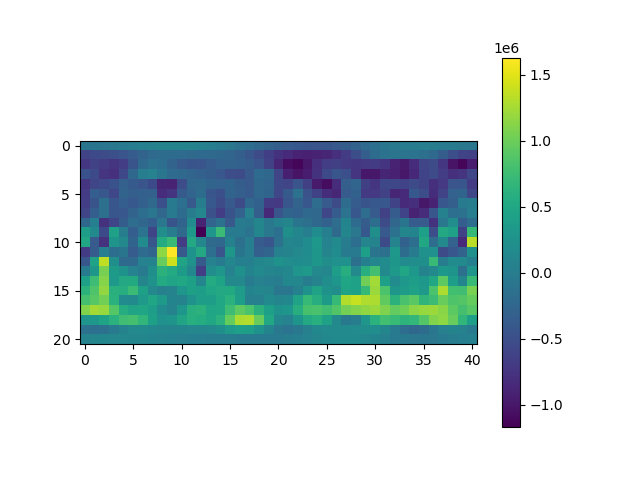

<IPython.core.display.Javascript object>


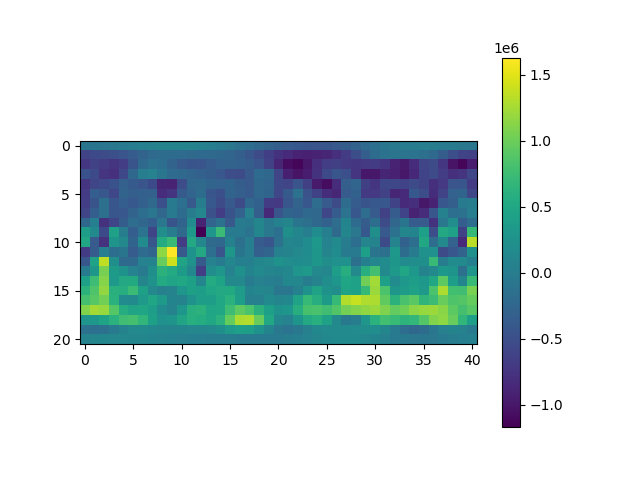

In [81]:
#plt.figure()
#plt.imshow(dat_prior.reshape(surface.grid_glq_nmax+1,2*surface.grid_glq_nmax+1))
#plt.colorbar()
#plt.show()

plt.figure()
plt.imshow(dat_sh.reshape(surface.grid_glq_nmax+1,2*surface.grid_glq_nmax+1))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(surface.data.reshape(surface.grid_glq_nmax+1,2*surface.grid_glq_nmax+1))
plt.colorbar()
plt.show()

In [82]:
#np.testing.assert_allclose(dat_prior.reshape(-1,),surface.data)
np.testing.assert_allclose(dat_sh.reshape(-1,),surface.data)
np.testing.assert_allclose(dat_test.reshape(-1,),surface.data)

____semi-variogram setup___

Number of data used: 741321
Max data distance: 3.133 km
Lag length chosen: 0.1 km
Number of lags: 31
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation

____semi-variogram setup___

Number of data used: 741321
Max data distance: 3.133 km
Lag length chosen: 0.1 km
Number of lags: 31
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


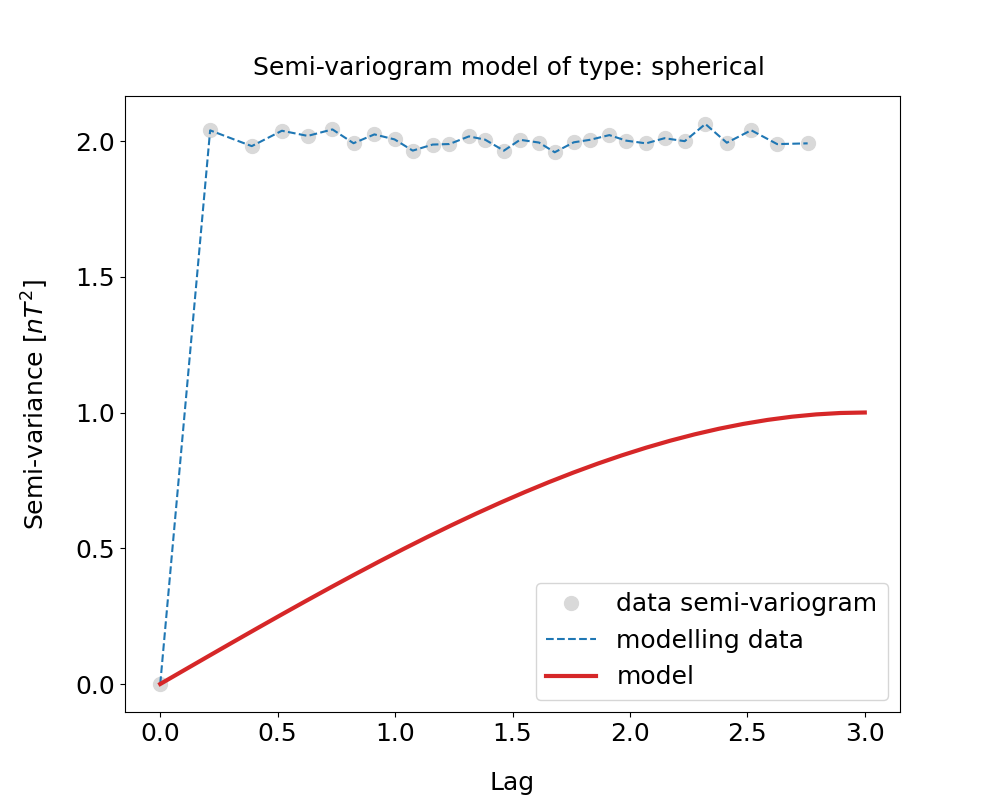

In [28]:
surface.semivar(model_lags = "all", model = "exponential", max_dist = 20, lag_length = 0.1,
             zero_nugget = True, hit_target_var = True)

#keep_sv_curve = core.sv_curve.copy()
#keep_lags_sv_curve = core.lags_sv_curve.copy()

C_e_const = 0.001

#nugget = C_e_const**2
nugget = 0.0
#nugget_p = 0.01
#var_fac = 1.0

#set_model = {"a": 2000, "C0": var_fac*core.target_var*nugget_p, "C1": var_fac*core.target_var*(1-nugget_p), "C2": None, "C3": None}
set_model = {"a": 3, "C0": nugget, "C1": 1-nugget, "C2": None, "C3": None}


surface.semivar(model_lags = 20, model = "spherical", max_dist = 20, lag_length = 0.1,
             zero_nugget = True, hit_target_var = True, set_model = set_model)

#core.semivar(model_lags = 3, model = "exponential", max_dist = 20000, lag_length = 200,
#             zero_nugget = True, hit_target_var = True)


#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 
plt.plot(surface.lags,surface.pics,'o', markersize=10,color = '0.85',label='data semi-variogram')
plt.plot(surface.lags_model,surface.pics_model,'--',markersize=10,label='modelling data')
plt.plot(surface.lags_sv_curve,surface.sv_curve,color='C3', linewidth = 3,label='model')
#plt.plot(keep_lags_sv_curve,keep_sv_curve,"--",color='C1',linewidth = 3,label='model large lag')

#plt.plot(surface.lags_sv_curve,np.ones(surface.lags_sv_curve.shape)*surface.target_var,linewidth = 3, color="C2", label="target histogram variance")
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % surface.model_names[surface.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [21]:
#print(core)

# Synthetic observations

In [29]:
s_obs = SDSS(comment, N_SH = shn, sim_type = "random_obs")

s_obs.grid_equal_area(N_grid = 500, r_at = 1)

grid_in = np.array([s_obs.grid_eqa_phi, 90-s_obs.grid_eqa_theta]).T
s_obs.make_grid(1, grid_in)

s_obs.r_grid = np.random.normal(loc=3.0, scale=0.5, size=(s_obs.N_grid,))

#s_sat.grid_equal_area(N_grid= 500, r_at = s_sat.r_sat, poles_remove = True)
#grid_in = np.array([s_sat.grid_eqa_phi, 90-s_sat.grid_eqa_theta]).T
#s_sat.grid(s_sat.r_sat, grid_in, calc_sph_d = False)


___ CHANGES TO GRID ___
N = 500, not compatible for equal area grid
N has been set to 499


In [30]:
print(s_obs)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          Generate map for simple example
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             20
N_SH_secondary:   None
sim_type:         random_obs
n_regions:        (1, 21)
s_cap:            (21,), Max/Min: 3.14 / 0.09
grid_eqa_radial:  (499,), Max/Min: 1.00 / 1.00
grid_eqa_theta:   (499,), Max/Min: 180.00 / 0.00
grid_eqa_phi:     (499,), Max/Min: 359.13 / 0.00
grid_eqa_N:       499
r_grid:           (499,), Max/Min: 4.48 / 1.43
grid:             (499, 2)
sph_d:            None
lon:              (499,), Max/Min: 359.13 / 0.00
lat:              (499,), Max/Min: 90.00 / -90.00
N_grid:           499



In [31]:
theta_s, theta_d, phi_s, phi_d = map(np.radians, 
                                     [90-surface.grid_glq_theta, 90-s_obs.grid_eqa_theta, 
                                      surface.grid_glq_phi-180, s_obs.grid_eqa_phi-180])

theta_diff = theta_s.reshape(1,-1) - theta_d.reshape(-1,1)
theta_diff[abs(theta_diff)>np.pi/4] = 0.0

phi_diff = phi_s.reshape(1,-1) - phi_d.reshape(-1,1)
phi_diff[abs(phi_diff)>np.pi/4] = 0.0


r_diff =  s_obs.r_grid.reshape(-1,1) - np.ones((1,surface.N_grid))*1
r_diff[abs(phi_diff)>np.pi/4] = 0.0
r_diff[abs(theta_diff)>np.pi/4] = 0.0

norm_len = np.sqrt(theta_diff**2 + phi_diff**2 + r_diff**2) #   

#G_norm = np.pi/60*norm_len*surface.grid_glq_w


surface.G = np.pi/(surface.grid_glq_nmax+0.5)*np.multiply(surface.grid_glq_w,norm_len) # +0.5 for parity with SHTOOLS

C_e = np.diag(C_e_const**2*np.ones(s_obs.N_grid,)) # No need to store C_e outside of here

surface.C_mm_all = surface.target_var-surface.sv_lut

surface.C_dm_all = surface.G@surface.C_mm_all

surface.C_dd = surface.C_dm_all@surface.G.T  + C_e

surface.C_dm_all = surface.C_dm_all.T

surface.C_e_const = C_e_const


s_obs.data = surface.G@surface.data

s_obs.data += np.random.normal(scale = C_e_const, size = s_obs.data.shape)

<IPython.core.display.Javascript object>


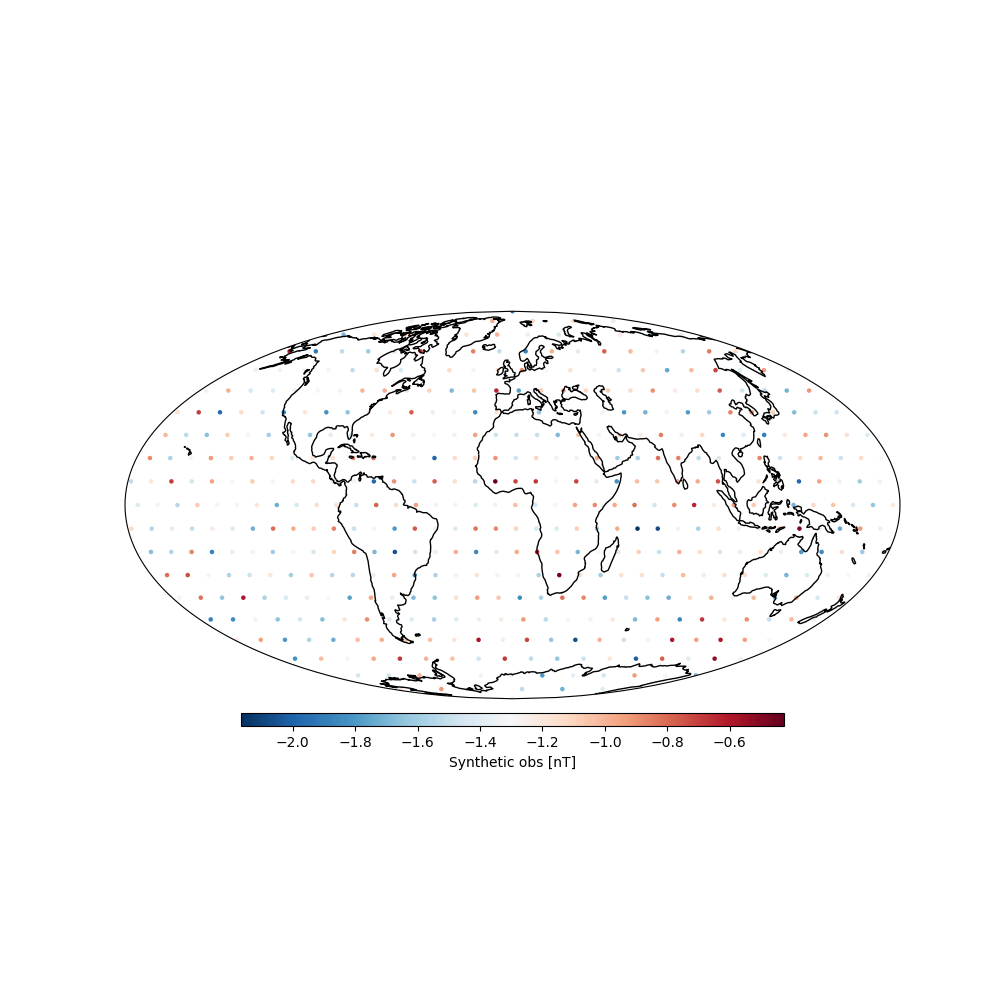

In [32]:
mt_util.plot_cartopy_global(lat = s_obs.lat, lon = s_obs.lon, plot_quality = "high", point_size=5, 
                            data=s_obs.data, title="Synthetic obs", scale_uneven = True)

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 861/861, Running error magnitude: -0.2
Run time: 5.424 seconds 
Total elapsed time: 0.090 minutes 
Variance: 0.299
Mean: 0.162
Max: 3.488
Min: -2.692
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 861/861, Running error magnitude: -0.1
Run time: 5.186 seconds 
Total elapsed time: 0.177 minutes 
Variance: 0.386
Mean: -0.343
Max: 2.691
Min: -3.222
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 861/861, Running error magnitude: -0.2
Run time: 5.290 seconds 
Total elapsed time: 0.265 minutes 
Variance: 0.293
Mean: 0.028
Max: 3.418
Min: -3.406
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 861/861, Running error magnitude: -0.1
Run time: 5.406 seconds 
Total elapsed time: 0.355 minutes 
Variance: 0.450
Mean: -0.877
Max: 1.736
Min: -2.410
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization nr. 4. Counter: 861/861, Running error magnitude: -0.1
Run time: 5.346 seconds 
Total elapsed time: 0.444 minut

<IPython.core.display.Javascript object>


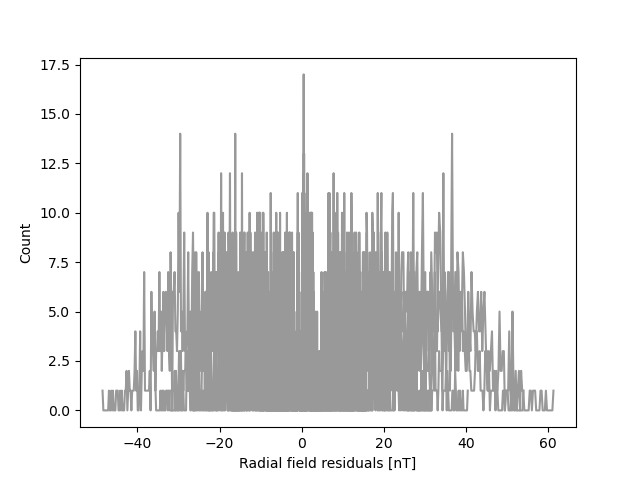

In [33]:
N_sim = 30

surface.run_sim(N_sim, surface.grid_glq_N, surface.C_mm_all, surface.C_dd, surface.C_dm_all, surface.G,
        s_obs.data, surface.data, scale_m_i = True, unit_d = False, collect_all = False,
        sense_running_error = True, save_string = nb_name, sim_stochastic = True, solve_cho=True)

<IPython.core.display.Javascript object>


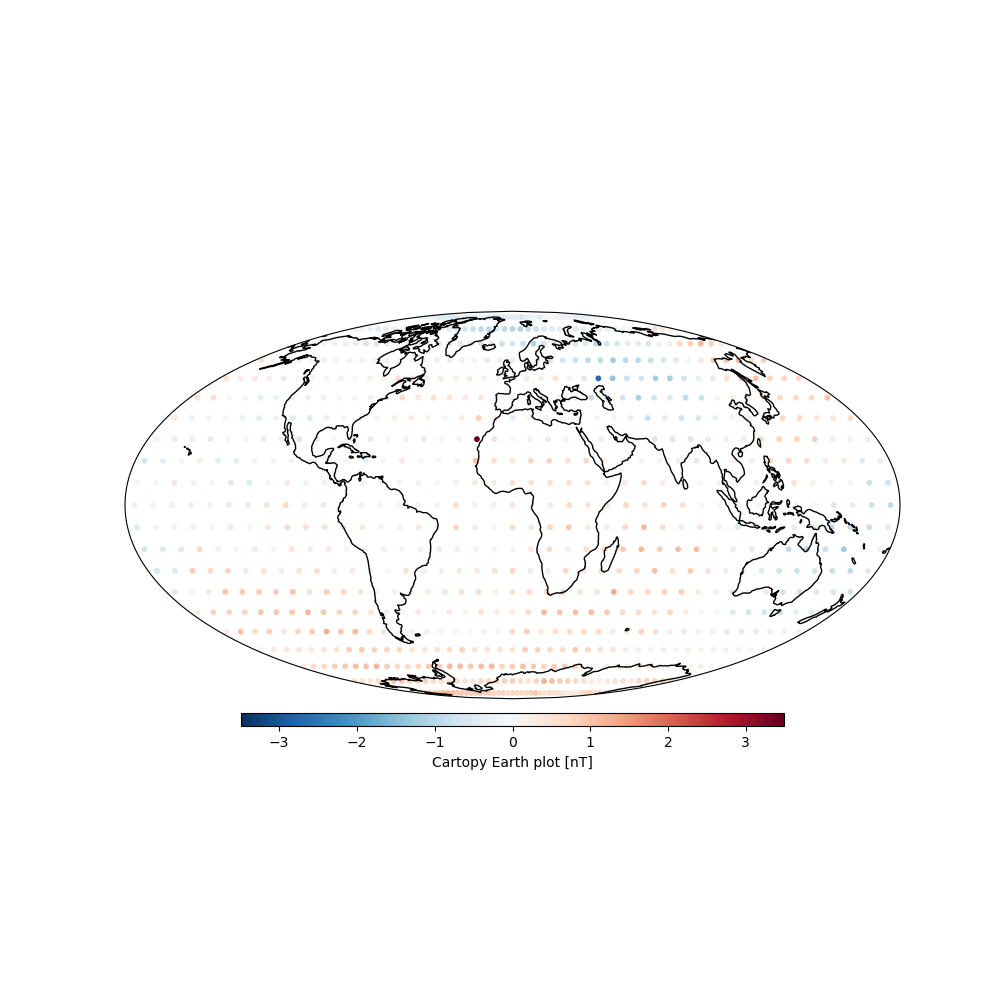

In [34]:
#mt_util.plot_cartopy_global(lat = surface.lat, lon = surface.lon, plot_quality = "high", 
#                            data=surface.data, point_size=10)

mt_util.plot_cartopy_global(lat = surface.lat, lon = surface.lon, plot_quality = "high", 
                            data=surface.m_DSS[:,0], point_size=10)

In [35]:
surface.realization_to_sh_coeff(1, set_nmax = shn, geomag_scale = False)

In [36]:
surface.covmod_lsq_equiv(s_obs.data, surface.C_mm_all, surface.G, 1.0, geomag_scale = False)

<IPython.core.display.Javascript object>


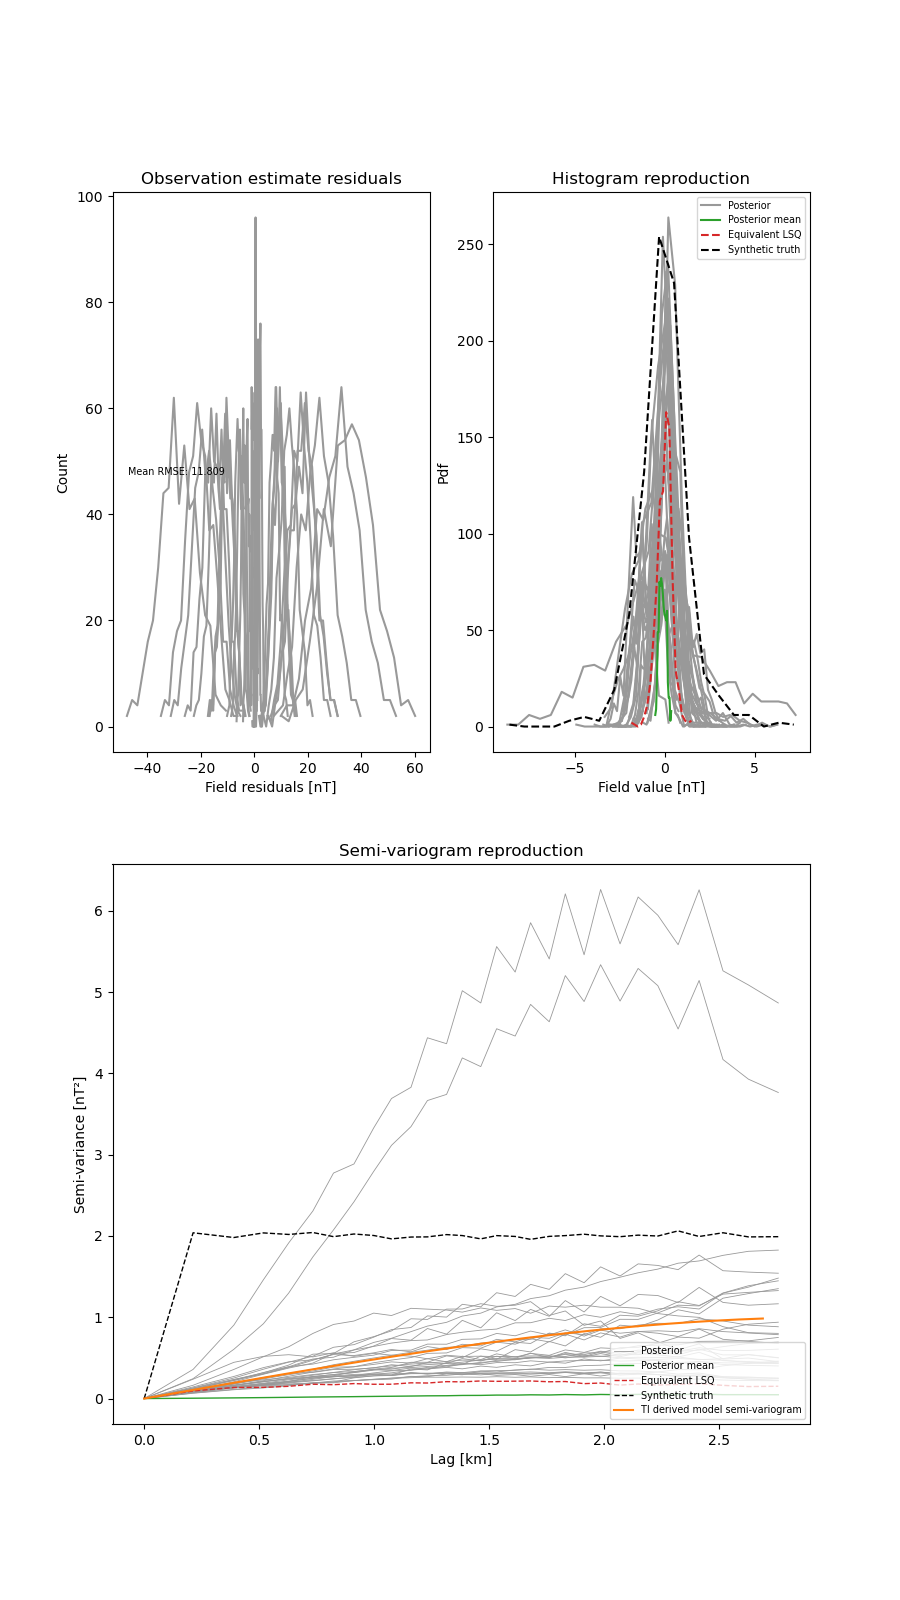

In [37]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

surface.grid_glq(nmax = shn, r_at = 1.0)
mt_util.plot_sdssim_reproduce(surface, surface.m_DSS_res, m_equiv_lsq = surface.m_equiv_lsq,
                              lags_use = 1000, spec_r_at = 1.0, spec_use = False,
                              model_dict = {}, figsize=(9,16),
                              hist_bins = 20, res_bins = 20,
                              savefig = False, save_string = "simple_ex", save_dpi = 100)

In [38]:
np.save("simple_ex_laplace",surface.m_DSS)

In [18]:
set_nmax = shn
r_at = 1.0

surface.grid_glq(nmax = 256, r_at = r_at)

zs_eqa = []
for i in np.arange(0,surface.g_spec.shape[1]):
    z_grid = mt_util.sh_makegrid_glq(surface.g_spec[:,i], surface.grid_glq_nmax, surface.grid_glq_zero, set_nmax)
    
    zs_eqa.append(z_grid.reshape(-1,))
    
zs_eqa = np.array(zs_eqa).T

zs_mean_eqa = mt_util.sh_makegrid_glq(surface.g_spec_mean, surface.grid_glq_nmax, surface.grid_glq_zero, set_nmax)

prior_eqa = mt_util.sh_makegrid_glq(surface.g_prior[:mt_util.shc_vec_len(set_nmax)], surface.grid_glq_nmax, surface.grid_glq_zero, set_nmax)

lsq_eqa = mt_util.sh_makegrid_glq(surface.g_lsq_equiv, surface.grid_glq_nmax, surface.grid_glq_zero, set_nmax)

<IPython.core.display.Javascript object>


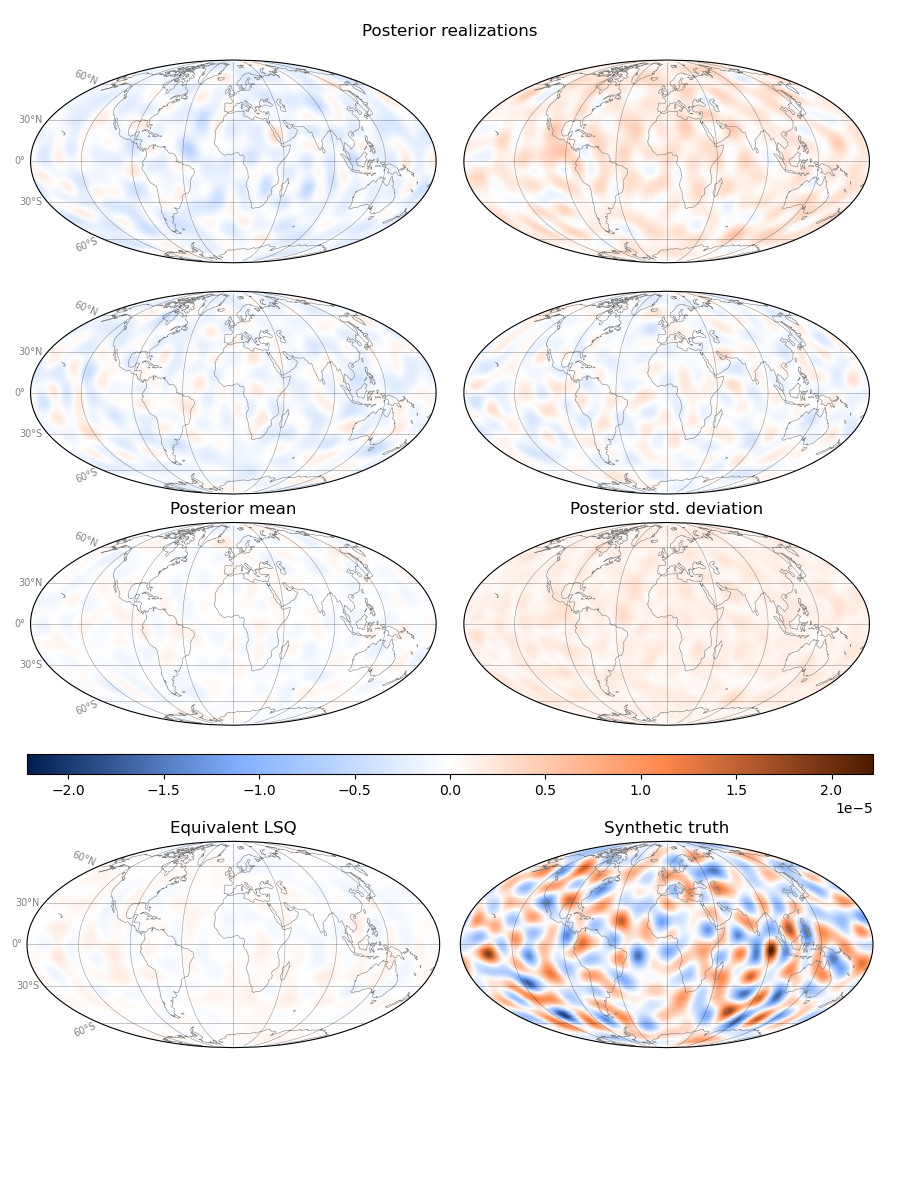

In [19]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(surface.grid_glq_phi, 90-surface.grid_glq_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = lsq_eqa, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10, cbar_mm_factor = 1,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.2, 
                        savefig = False, save_string = "simple_ex", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


In [ ]:
# SAVE RESULT
#print("\nSaving job")
#file_clip = open("core_{}.obj".format(nb_name), "wb")
#pickle.dump(core, file_clip, protocol=4)
#file_clip.close()

#file_clip = open("sat_{}.obj".format(nb_name), "wb")
#pickle.dump(s_sat, file_clip, protocol=4)
#file_clip.close()
#print("\nJob saved and finished")